# Bone Age Prediction from Hand Radiographs

Pattern Recognition and Machine Learning Course Project

This notebook implements both regression and classification models to predict bone age from hand X-ray images.

In [1]:
import tensorflow as tf
print('GPU CONFIGURATION')

# List all physical devices
print('All devices:', tf.config.list_physical_devices())

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'GPU ENABLED: {len(gpus)} GPU(s) detected')
        print(f'GPU Name: {gpus[0].name}')
        print('M1 Metal GPU is active!')
    except RuntimeError as e:
        print(f'GPU configuration error: {e}')
else:
    print('No GPU detected - running on CPU')
    print('Make sure tensorflow-metal is installed')

GPU CONFIGURATION
All devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU ENABLED: 1 GPU(s) detected
GPU Name: /physical_device:GPU:0
M1 Metal GPU is active!


## 1. Setup and Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from skimage.feature import hog, local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
import pickle
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print('Imports complete')

Imports complete


## 2. Configuration

In [3]:
TRAIN_CSV = 'dataset/boneage-training-dataset.csv'
TEST_CSV = 'dataset/boneage-test-dataset.csv'
TRAIN_DIR = 'dataset/boneage-training-dataset/boneage-training-dataset/'
TEST_DIR = 'dataset/boneage-test-dataset/'

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
RANDOM_STATE = 42

# Make required folders
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('results/scatter_plots', exist_ok=True)
os.makedirs('results/heatmaps', exist_ok=True)
os.makedirs('results/confusion_matrix', exist_ok=True)
os.makedirs('report', exist_ok=True)

print('Configuration complete')

Configuration complete


## 3. Data Loading and Exploration

In [4]:
#Load the shape of the data
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)

print('Training samples:', len(df_train))
print('Test samples:', len(df_test))
print('\nTraining data columns:', df_train.columns.tolist())
print('\nFirst 5 rows:')
print(df_train.head())
print('\nData statistics:')
print(df_train.describe())

Training samples: 12611
Test samples: 200

Training data columns: ['id', 'boneage', 'male']

First 5 rows:
     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

Data statistics:
                 id       boneage
count  12611.000000  12611.000000
mean    8537.653001    127.320752
std     4108.763993     41.182021
min     1377.000000      1.000000
25%     5074.500000     96.000000
50%     8565.000000    132.000000
75%    12091.500000    156.000000
max    15610.000000    228.000000


In [5]:
df_train['age_years'] = df_train['boneage'] / 12.0

# Check if test dataset has bone age column
if 'boneage' in df_test.columns:
    df_test['age_years'] = df_test['boneage'] / 12.0
else:
    print("Note: Test dataset doesn't have bone age labels.")
    print("Using part of training data as test set instead...")
    
    # Split training data: 70% train, 15% val, 15% test
    from sklearn.model_selection import train_test_split
    
    # Create age categories first for stratification
    def create_age_bins(age_years):
        if age_years <= 10:
            return 0
        elif age_years <= 17:
            return 1
        else:
            return 2
    
    df_train['age_category'] = df_train['age_years'].apply(create_age_bins)
    
    # Split: 85% for train+val, 15% for test
    df_train_temp, df_test = train_test_split(
        df_train, 
        test_size=0.15, 
        random_state=RANDOM_STATE, 
        stratify=df_train['age_category']
    )
    
    # Now df_train_temp will be split again into train and val
    df_train = df_train_temp
    df_test['age_years'] = df_test['boneage'] / 12.0
    df_test['age_category'] = df_test['age_years'].apply(create_age_bins)
    
    print(f"New split: Train={len(df_train)}, Test={len(df_test)}")

print('Age range:', df_train['age_years'].min(), 'to', df_train['age_years'].max(), 'years')
print('Mean age:', df_train['age_years'].mean(), 'years')
print('\nGender distribution:')
print(df_train['male'].value_counts())


Note: Test dataset doesn't have bone age labels.
Using part of training data as test set instead...
New split: Train=10719, Test=1892
Age range: 0.08333333333333333 to 19.0 years
Mean age: 10.614757284572566 years

Gender distribution:
male
True     5805
False    4914
Name: count, dtype: int64


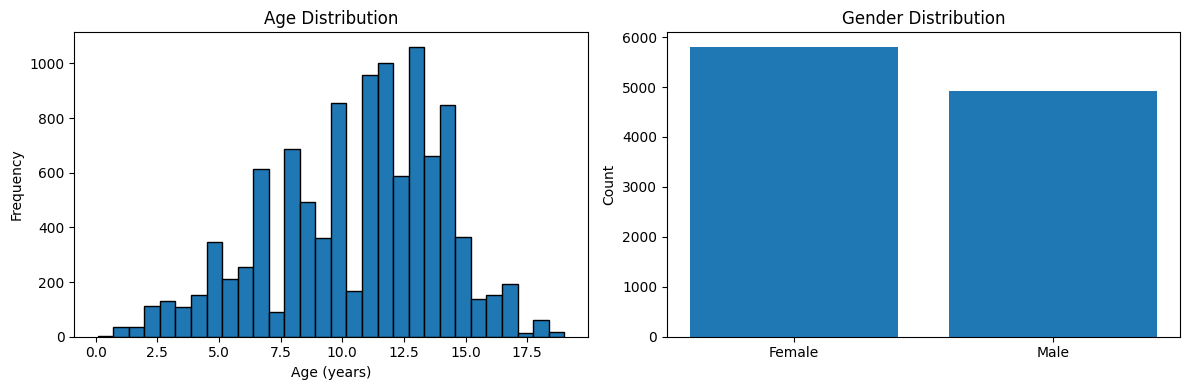

In [6]:
# Age and Gender Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df_train['age_years'], bins=30, edgecolor='black')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution')
axes[1].bar(['Female', 'Male'], df_train['male'].value_counts().values)
axes[1].set_ylabel('Count')
axes[1].set_title('Gender Distribution')
plt.tight_layout()
plt.savefig('results/data_distribution.png')
plt.show()

## 4. Sample Image Visualization

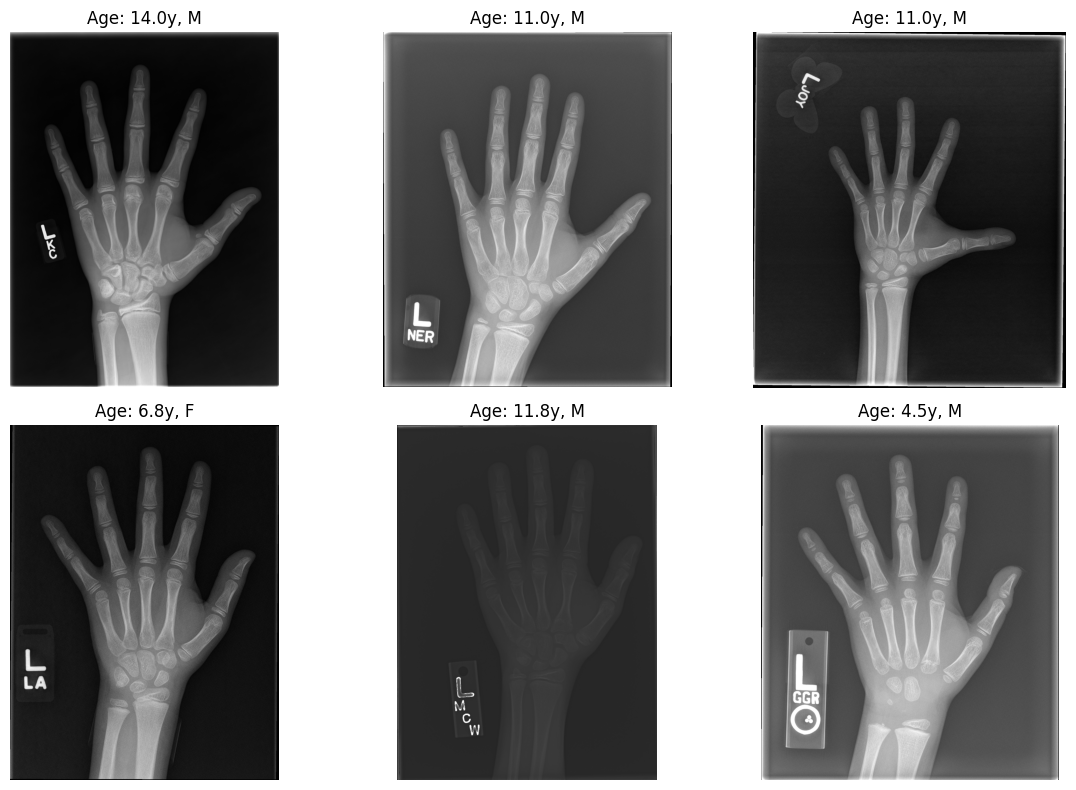

Successfully displayed 6 sample images


In [7]:
import os
from PIL import Image

# Sample from df_train (the actual training split)
sample_attempts = min(50, len(df_train))  # Try up to 50 samples
sample_ids = df_train.sample(sample_attempts, random_state=RANDOM_STATE)
valid_samples = []

for idx, row in sample_ids.iterrows():
    img_path = os.path.join(TRAIN_DIR, f"{row['id']}.png")
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path)
            img.verify()  # Check if image is valid
            valid_samples.append((row, img_path))
            if len(valid_samples) == 6:
                break
        except Exception as e:
            print(f"Skipping {row['id']}.png: {e}")
            continue
    else:
        print(f"File not found: {img_path}")

if len(valid_samples) == 0:
    print(f"ERROR: No valid images found!")
    print(f"Checked directory: {TRAIN_DIR}")
    print(f"Sample ID to check: {df_train.iloc[0]['id']}")
    print(f"Expected path: {os.path.join(TRAIN_DIR, str(df_train.iloc[0]['id']) + '.png')}")
    print(f"Directory exists: {os.path.exists(TRAIN_DIR)}")
    
    # List first few files in directory
    if os.path.exists(TRAIN_DIR):
        files = os.listdir(TRAIN_DIR)[:5]
        print(f"First 5 files in directory: {files}")
else:
    # Create the plot
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for idx, (row, img_path) in enumerate(valid_samples):
        img = Image.open(img_path)
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"Age: {row['age_years']:.1f}y, {'M' if row['male'] else 'F'}")
        axes[idx].axis('off')

    # Hide unused subplots
    for idx in range(len(valid_samples), 6):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('results/sample_images.png')
    plt.show()

    print(f"Successfully displayed {len(valid_samples)} sample images")

## 5. Age Binning for Classification

In [8]:
def create_age_bins(age_years):
    if age_years <= 10:
        return 0  # Child
    elif age_years <= 17:
        return 1  # Adolescent
    else:
        return 2  # Adult

df_train['age_category'] = df_train['age_years'].apply(create_age_bins)
df_test['age_category'] = df_test['age_years'].apply(create_age_bins)

print('Category distribution:')
print(df_train['age_category'].value_counts().sort_index())
print('\nCategory labels: 0=Child (0-10y), 1=Adolescent (11-17y), 2=Adult (18+y)')

Category distribution:
age_category
0    4488
1    6138
2      93
Name: count, dtype: int64

Category labels: 0=Child (0-10y), 1=Adolescent (11-17y), 2=Adult (18+y)


## 6. Train/Val/Test Split

In [9]:
# Split the data - 75, 15, 15
train_df, val_df = train_test_split(df_train, test_size=0.15, random_state=RANDOM_STATE, stratify=df_train['age_category'])

print('Training set:', len(train_df))
print('Validation set:', len(val_df))
print('Test set:', len(df_test))

Training set: 9111
Validation set: 1608
Test set: 1892


## 7. Classical ML - Feature Extraction Functions

In [10]:
def load_and_preprocess_image(img_path, img_size=IMG_SIZE):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    return img

def extract_hog_features(img):
    features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return features

def extract_lbp_features(img, radius=3, n_points=24):
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_glcm_features(img):
    img_uint = (img / img.max() * 255).astype(np.uint8)
    glcm = graycomatrix(img_uint, [1], [0, np.pi/4, np.pi/2], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    return np.concatenate([contrast, homogeneity, energy, correlation])

def extract_all_features(img_path):
    img = load_and_preprocess_image(img_path)
    hog_feat = extract_hog_features(img)
    lbp_feat = extract_lbp_features(img)
    glcm_feat = extract_glcm_features(img)
    return np.concatenate([hog_feat, lbp_feat, glcm_feat])

print('Feature extraction functions defined')

Feature extraction functions defined


## 8. Extract Features for Classical ML

In [11]:
import os

def extract_features_for_dataset(df, img_dir):
    features = []
    skipped = []
    for idx, row in df.iterrows():
        img_path = os.path.join(img_dir, f"{row['id']}.png")
        
        if not os.path.exists(img_path):
            skipped.append(row['id'])
            continue
            
        try:
            feat = extract_all_features(img_path)
            features.append(feat)
            if (len(features) % 1000) == 0:
                print(f'Processed {len(features)} images')
        except Exception as e:
            print(f"Error with {row['id']}: {e}")
            skipped.append(row['id'])
            continue
    
    if skipped:
        print(f"Skipped {len(skipped)} images")
    
    return np.array(features), skipped

# Create cache directory
os.makedirs('cache', exist_ok=True)

# Check if cached features exist
cache_exists = (os.path.exists('cache/X_train.npy') and 
                os.path.exists('cache/X_val.npy') and 
                os.path.exists('cache/X_test.npy'))

if cache_exists:
    print('LOADING CACHED FEATURES')
    X_train_classical = np.load('cache/X_train.npy')
    X_val_classical = np.load('cache/X_val.npy')
    X_test_classical = np.load('cache/X_test.npy')
    print('Cached features loaded!')
    print(f'Feature shape: {X_train_classical.shape}')
else:
    print('NO CACHE FOUND - EXTRACTING FEATURES')
    print('This will take ~9 minutes but only runs once!')
    
    print('\nExtracting training features...')
    X_train_classical, train_skip = extract_features_for_dataset(train_df, TRAIN_DIR)
    
    print('\nExtracting validation features...')
    X_val_classical, val_skip = extract_features_for_dataset(val_df, TRAIN_DIR)
    
    print('\nExtracting test features...')
    X_test_classical, test_skip = extract_features_for_dataset(df_test, TRAIN_DIR)
    
    # Remove skipped IDs
    if train_skip:
        train_df = train_df[~train_df['id'].isin(train_skip)].reset_index(drop=True)
    if val_skip:
        val_df = val_df[~val_df['id'].isin(val_skip)].reset_index(drop=True)
    if test_skip:
        df_test = df_test[~df_test['id'].isin(test_skip)].reset_index(drop=True)
    
    # Save to cache
    print('\nSaving features to cache for future runs...')
    np.save('cache/X_train.npy', X_train_classical)
    np.save('cache/X_val.npy', X_val_classical)
    np.save('cache/X_test.npy', X_test_classical)
    print('Features cached!')
    
    print(f'\nFeature shape: {X_train_classical.shape}')
    print(f'Final counts - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(df_test)}')


LOADING CACHED FEATURES
Cached features loaded!
Feature shape: (9111, 26282)


In [12]:
y_train_reg = train_df['age_years'].values
y_val_reg = val_df['age_years'].values
y_test_reg = df_test['age_years'].values

y_train_cls = train_df['age_category'].values
y_val_cls = val_df['age_category'].values
y_test_cls = df_test['age_category'].values

scaler = StandardScaler()
X_train_classical = scaler.fit_transform(X_train_classical)
X_val_classical = scaler.transform(X_val_classical)
X_test_classical = scaler.transform(X_test_classical)

with open('models/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print('Features normalized')

Features normalized


## 9. Classical ML - Regression Models

In [13]:
"""

print('Training Random Forest Regressor...')
rf_reg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_reg.fit(X_train_classical, y_train_reg)

y_pred_train = rf_reg.predict(X_train_classical)
y_pred_val = rf_reg.predict(X_val_classical)
y_pred_test = rf_reg.predict(X_test_classical)

train_mae = mean_absolute_error(y_train_reg, y_pred_train)
val_mae = mean_absolute_error(y_val_reg, y_pred_val)
test_mae = mean_absolute_error(y_test_reg, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_val))
test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test))

train_r2 = r2_score(y_train_reg, y_pred_train)
val_r2 = r2_score(y_val_reg, y_pred_val)
test_r2 = r2_score(y_test_reg, y_pred_test)

print(f'\nRandom Forest Regression Results:')
print(f'Train - MAE: {train_mae:.3f}, RMSE: {train_rmse:.3f}, R2: {train_r2:.3f}')
print(f'Val   - MAE: {val_mae:.3f}, RMSE: {val_rmse:.3f}, R2: {val_r2:.3f}')
print(f'Test  - MAE: {test_mae:.3f}, RMSE: {test_rmse:.3f}, R2: {test_r2:.3f}')

with open('models/rf_regressor.pkl', 'wb') as f:
    pickle.dump(rf_reg, f)

classical_reg_results = {
    'model': 'Random Forest',
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'predictions': y_pred_test
}

"""

"\n\nprint('Training Random Forest Regressor...')\nrf_reg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)\nrf_reg.fit(X_train_classical, y_train_reg)\n\ny_pred_train = rf_reg.predict(X_train_classical)\ny_pred_val = rf_reg.predict(X_val_classical)\ny_pred_test = rf_reg.predict(X_test_classical)\n\ntrain_mae = mean_absolute_error(y_train_reg, y_pred_train)\nval_mae = mean_absolute_error(y_val_reg, y_pred_val)\ntest_mae = mean_absolute_error(y_test_reg, y_pred_test)\n\ntrain_rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred_train))\nval_rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_val))\ntest_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test))\n\ntrain_r2 = r2_score(y_train_reg, y_pred_train)\nval_r2 = r2_score(y_val_reg, y_pred_val)\ntest_r2 = r2_score(y_test_reg, y_pred_test)\n\nprint(f'\nRandom Forest Regression Results:')\nprint(f'Train - MAE: {train_mae:.3f}, RMSE: {train_rmse:.3f}, R2: {train_r2:.3f}')\nprint(f'Val   - MAE: {val_ma

In [14]:
import os
import pickle

# Check if model already exists
if os.path.exists('models/rf_regressor.pkl'):
    print('LOADING SAVED RANDOM FOREST REGRESSOR (saves 9 mins!)')
    with open('models/rf_regressor.pkl', 'rb') as f:
        rf_reg = pickle.load(f)
    print('Model loaded from models/rf_regressor.pkl')
else:
    print('NO SAVED MODEL - TRAINING RANDOM FOREST REGRESSOR')
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf_reg.fit(X_train_classical, y_train_reg)
    
    # Save for future runs
    with open('models/rf_regressor.pkl', 'wb') as f:
        pickle.dump(rf_reg, f)
    print('Model trained and saved!')

# Always compute predictions and metrics
y_pred_train = rf_reg.predict(X_train_classical)
y_pred_val = rf_reg.predict(X_val_classical)
y_pred_test = rf_reg.predict(X_test_classical)

train_mae = mean_absolute_error(y_train_reg, y_pred_train)
val_mae = mean_absolute_error(y_val_reg, y_pred_val)
test_mae = mean_absolute_error(y_test_reg, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_val))
test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test))

train_r2 = r2_score(y_train_reg, y_pred_train)
val_r2 = r2_score(y_val_reg, y_pred_val)
test_r2 = r2_score(y_test_reg, y_pred_test)

print(f'\nRandom Forest Regression Results:')
print(f'Train - MAE: {train_mae:.3f}, RMSE: {train_rmse:.3f}, R2: {train_r2:.3f}')
print(f'Val   - MAE: {val_mae:.3f}, RMSE: {val_rmse:.3f}, R2: {val_r2:.3f}')
print(f'Test  - MAE: {test_mae:.3f}, RMSE: {test_rmse:.3f}, R2: {test_r2:.3f}')

classical_reg_results = {
    'model': 'Random Forest',
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'predictions': y_pred_test
}

LOADING SAVED RANDOM FOREST REGRESSOR (saves 9 mins!)
Model loaded from models/rf_regressor.pkl

Random Forest Regression Results:
Train - MAE: 0.874, RMSE: 1.095, R2: 0.899
Val   - MAE: 2.320, RMSE: 2.861, R2: 0.278
Test  - MAE: 2.314, RMSE: 2.899, R2: 0.273


## 10. Classical ML - Classification Models

In [15]:
"""

print('Training Random Forest Classifier...')
rf_cls = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_cls.fit(X_train_classical, y_train_cls)

y_pred_cls_train = rf_cls.predict(X_train_classical)
y_pred_cls_val = rf_cls.predict(X_val_classical)
y_pred_cls_test = rf_cls.predict(X_test_classical)

train_acc = accuracy_score(y_train_cls, y_pred_cls_train)
val_acc = accuracy_score(y_val_cls, y_pred_cls_val)
test_acc = accuracy_score(y_test_cls, y_pred_cls_test)

precision, recall, f1, _ = precision_recall_fscore_support(y_test_cls, y_pred_cls_test, average='weighted')
qwk = cohen_kappa_score(y_test_cls, y_pred_cls_test, weights='quadratic')

print(f'\nRandom Forest Classification Results:')
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Val Accuracy: {val_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print(f'Quadratic Weighted Kappa: {qwk:.3f}')

with open('models/rf_classifier.pkl', 'wb') as f:
    pickle.dump(rf_cls, f)

classical_cls_results = {
    'model': 'Random Forest',
    'test_acc': test_acc,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'qwk': qwk,
    'predictions': y_pred_cls_test
}

"""

"\n\nprint('Training Random Forest Classifier...')\nrf_cls = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)\nrf_cls.fit(X_train_classical, y_train_cls)\n\ny_pred_cls_train = rf_cls.predict(X_train_classical)\ny_pred_cls_val = rf_cls.predict(X_val_classical)\ny_pred_cls_test = rf_cls.predict(X_test_classical)\n\ntrain_acc = accuracy_score(y_train_cls, y_pred_cls_train)\nval_acc = accuracy_score(y_val_cls, y_pred_cls_val)\ntest_acc = accuracy_score(y_test_cls, y_pred_cls_test)\n\nprecision, recall, f1, _ = precision_recall_fscore_support(y_test_cls, y_pred_cls_test, average='weighted')\nqwk = cohen_kappa_score(y_test_cls, y_pred_cls_test, weights='quadratic')\n\nprint(f'\nRandom Forest Classification Results:')\nprint(f'Train Accuracy: {train_acc:.3f}')\nprint(f'Val Accuracy: {val_acc:.3f}')\nprint(f'Test Accuracy: {test_acc:.3f}')\nprint(f'Precision: {precision:.3f}')\nprint(f'Recall: {recall:.3f}')\nprint(f'F1-Score: {f1:.3f}')\nprint(f'Quadratic Weighte

In [16]:
# Check if classifier already exists
if os.path.exists('models/rf_classifier.pkl'):
    print('LOADING SAVED RANDOM FOREST CLASSIFIER (saves 9 mins!)')
    with open('models/rf_classifier.pkl', 'rb') as f:
        rf_cls = pickle.load(f)
    print('Model loaded from models/rf_classifier.pkl')
else:
    print('NO SAVED MODEL - TRAINING RANDOM FOREST CLASSIFIER')
    rf_cls = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf_cls.fit(X_train_classical, y_train_cls)
    
    # Save for future runs
    with open('models/rf_classifier.pkl', 'wb') as f:
        pickle.dump(rf_cls, f)
    print('Model trained and saved!')

# Always compute predictions and metrics
y_pred_cls_train = rf_cls.predict(X_train_classical)
y_pred_cls_val = rf_cls.predict(X_val_classical)
y_pred_cls_test = rf_cls.predict(X_test_classical)

train_acc = accuracy_score(y_train_cls, y_pred_cls_train)
val_acc = accuracy_score(y_val_cls, y_pred_cls_val)
test_acc = accuracy_score(y_test_cls, y_pred_cls_test)

precision, recall, f1, _ = precision_recall_fscore_support(y_test_cls, y_pred_cls_test, average='weighted')
qwk = cohen_kappa_score(y_test_cls, y_pred_cls_test, weights='quadratic')

print(f'\nRandom Forest Classification Results:')
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Val Accuracy: {val_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print(f'Quadratic Weighted Kappa: {qwk:.3f}')

classical_cls_results = {
    'model': 'Random Forest',
    'test_acc': test_acc,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'qwk': qwk,
    'predictions': y_pred_cls_test
}

LOADING SAVED RANDOM FOREST CLASSIFIER (saves 9 mins!)
Model loaded from models/rf_classifier.pkl

Random Forest Classification Results:
Train Accuracy: 1.000
Val Accuracy: 0.678
Test Accuracy: 0.662
Precision: 0.655
Recall: 0.662
F1-Score: 0.645
Quadratic Weighted Kappa: 0.289


## 11. Machine Learning - Data Generators

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

def create_regression_generator(datagen, df, img_dir, batch_size):
    while True:
        indices = np.random.choice(len(df), batch_size)
        batch_images = []
        batch_labels = []
        for idx in indices:
            row = df.iloc[idx]
            img_path = os.path.join(img_dir, f"{row['id']}.png")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = np.stack([img]*3, axis=-1)
            img = img / 255.0
            batch_images.append(img)
            batch_labels.append(row['age_years'])
        yield np.array(batch_images), np.array(batch_labels)

train_gen_reg = create_regression_generator(train_datagen, train_df.reset_index(drop=True), TRAIN_DIR, BATCH_SIZE)
val_gen_reg = create_regression_generator(val_datagen, val_df.reset_index(drop=True), TRAIN_DIR, BATCH_SIZE)

print('Data generators created')

Data generators created


In [18]:
# SSL Fix for downloading ResNet50 weights on Mac
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
print('SSL certificate verification disabled for downloading pretrained weights')

SSL certificate verification disabled for downloading pretrained weights


## 12. Machine Learning - Regression Model

In [19]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear')(x)

cnn_reg_model = Model(inputs=base_model.input, outputs=output)
cnn_reg_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mae', metrics=['mae'])

print('CNN Regression Model Summary:')
print(f'Total parameters: {cnn_reg_model.count_params()}')

2025-12-03 11:44:10.536108: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-03 11:44:10.537022: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-03 11:44:10.537033: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-03 11:44:10.537073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 11:44:10.537284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


CNN Regression Model Summary:
Total parameters: 24112513


In [20]:
"""

EPOCHS = 100  # instead of 50
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),  # More patience
    ModelCheckpoint('models/cnn_regressor.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=10)  # More patience here too
]

# Use lower learning rate
cnn_reg_model.compile(
    optimizer=keras.optimizers.Adam(5e-5),  # Half the previous rate
    loss='mae',
    metrics=['mae']
)
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

print('Training Regression Model...')
history_reg = cnn_reg_model.fit(
    train_gen_reg,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen_reg,
    validation_steps=validation_steps,
    callbacks=callbacks
)

print('Training complete') 

"""

"\n\nEPOCHS = 100  # instead of 50\ncallbacks = [\n    EarlyStopping(patience=20, restore_best_weights=True),  # More patience\n    ModelCheckpoint('models/cnn_regressor.h5', save_best_only=True),\n    ReduceLROnPlateau(factor=0.5, patience=10)  # More patience here too\n]\n\n# Use lower learning rate\ncnn_reg_model.compile(\n    optimizer=keras.optimizers.Adam(5e-5),  # Half the previous rate\n    loss='mae',\n    metrics=['mae']\n)\nsteps_per_epoch = len(train_df) // BATCH_SIZE\nvalidation_steps = len(val_df) // BATCH_SIZE\n\nprint('Training Regression Model...')\nhistory_reg = cnn_reg_model.fit(\n    train_gen_reg,\n    steps_per_epoch=steps_per_epoch,\n    epochs=EPOCHS,\n    validation_data=val_gen_reg,\n    validation_steps=validation_steps,\n    callbacks=callbacks\n)\n\nprint('Training complete') \n\n"

In [ ]:
import os
from tensorflow.keras.models import load_model
from tensorflow import keras

# Check if trained model already exists
if os.path.exists('models/cnn_regressor.h5'):
    print('LOADING SAVED CNN REGRESSION MODEL (saves 35 mins!)')
    
    # Load without compiling (avoids the error)
    cnn_reg_model = load_model('models/cnn_regressor.h5', compile=False)
    
    # Recompile manually
    cnn_reg_model.compile(
        optimizer=keras.optimizers.Adam(1e-4), 
        loss='mae', 
        metrics=['mae']
    )
    
    print('CNN model loaded and recompiled!')
    history_reg = None 

LOADING SAVED CNN REGRESSION MODEL (saves 35 mins!)
CNN model loaded and recompiled!


## 13. Regression Evaluation

In [22]:
def predict_cnn_regression(model, df, img_dir):
    predictions = []
    for idx, row in df.iterrows():
        img_path = os.path.join(img_dir, f"{row['id']}.png")
        
        # Check if file exists
        if not os.path.exists(img_path):
            predictions.append(0)  # Default prediction
            continue
            
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Check if image loaded successfully
        if img is None:
            predictions.append(0)
            continue
            
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.stack([img]*3, axis=-1)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img, verbose=0)[0][0]
        predictions.append(pred)
    return np.array(predictions)

print('Generating CNN predictions...')
# Use TRAIN_DIR because test set is split from training data!
cnn_pred_test = predict_cnn_regression(cnn_reg_model, df_test, TRAIN_DIR)

cnn_mae = mean_absolute_error(y_test_reg, cnn_pred_test)
cnn_rmse = np.sqrt(mean_squared_error(y_test_reg, cnn_pred_test))
cnn_r2 = r2_score(y_test_reg, cnn_pred_test)

print(f'\nCNN Regression Results:')
print(f'Test MAE: {cnn_mae:.3f}')
print(f'Test RMSE: {cnn_rmse:.3f}')
print(f'Test R2: {cnn_r2:.3f}')

cnn_reg_results = {
    'model': 'CNN ResNet50',
    'test_mae': cnn_mae,
    'test_rmse': cnn_rmse,
    'test_r2': cnn_r2,
    'predictions': cnn_pred_test
}

Generating CNN predictions...


2025-12-03 11:44:17.230916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



CNN Regression Results:
Test MAE: 2.627
Test RMSE: 3.306
Test R2: 0.055


PART 1: CNN CLASSIFICATION MODEL
LOADING SAVED CNN CLASSIFIER (saves 40 mins!)
Model loaded!
PART 2: EVALUATE CNN CLASSIFICATION

Generating CNN classification predictions...
  Predicted 50/1892 images
  Predicted 100/1892 images
  Predicted 150/1892 images
  Predicted 200/1892 images
  Predicted 250/1892 images
  Predicted 300/1892 images
  Predicted 350/1892 images
  Predicted 400/1892 images
  Predicted 450/1892 images
  Predicted 500/1892 images
  Predicted 550/1892 images
  Predicted 600/1892 images
  Predicted 650/1892 images
  Predicted 700/1892 images
  Predicted 750/1892 images
  Predicted 800/1892 images
  Predicted 850/1892 images
  Predicted 900/1892 images
  Predicted 950/1892 images
  Predicted 1000/1892 images
  Predicted 1050/1892 images
  Predicted 1100/1892 images
  Predicted 1150/1892 images
  Predicted 1200/1892 images
  Predicted 1250/1892 images
  Predicted 1300/1892 images
  Predicted 1350/1892 images
  Predicted 1400/1892 images
  Predicted 1450/1892 images
  Pr

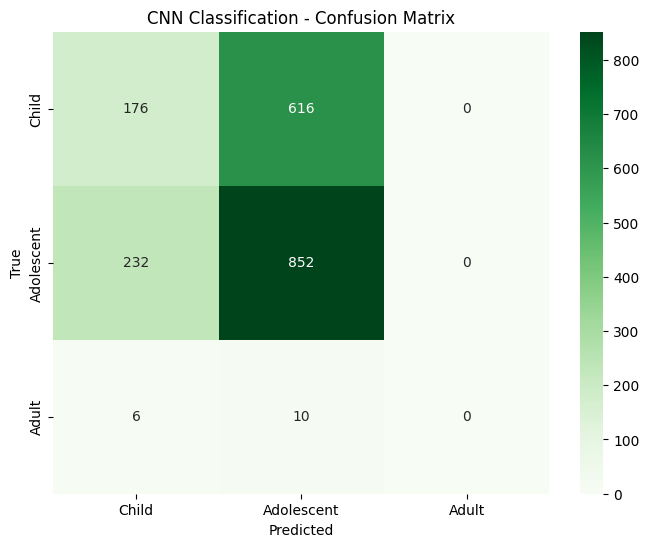

In [23]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

print('PART 1: CNN CLASSIFICATION MODEL')
# Check if model exists
if os.path.exists('models/cnn_classifier.h5'):
    print('LOADING SAVED CNN CLASSIFIER (saves 40 mins!)')
    
    cnn_cls_model = load_model('models/cnn_classifier.h5', compile=False)
    cnn_cls_model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print('Model loaded!')

else:
    print('NO SAVED MODEL - TRAINING CNN CLASSIFIER')

    # Build CNN Classification Model
    base_model_cls = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model_cls.trainable = False

    x = base_model_cls.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)

    cnn_cls_model = Model(inputs=base_model_cls.input, outputs=output)
    cnn_cls_model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f'CNN Classification Model built: {cnn_cls_model.count_params():,} parameters')

    # Create classification generator
    def create_classification_generator(df, img_dir, batch_size):
        while True:
            indices = np.random.choice(len(df), batch_size)
            batch_images, batch_labels = [], []

            for idx in indices:
                row = df.iloc[idx]
                img_path = os.path.join(img_dir, f"{row['id']}.png")

                if not os.path.exists(img_path):
                    continue

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = np.stack([img] * 3, axis=-1) / 255.0

                batch_images.append(img)
                batch_labels.append(row['age_category'])

            if len(batch_images) == 0:
                continue

            batch_labels_cat = to_categorical(batch_labels, num_classes=3)
            yield np.array(batch_images), batch_labels_cat

    train_gen_cls = create_classification_generator(train_df.reset_index(drop=True), TRAIN_DIR, BATCH_SIZE)
    val_gen_cls = create_classification_generator(val_df.reset_index(drop=True), TRAIN_DIR, BATCH_SIZE)

    print('\nTraining CNN Classification (~40 mins)...')

    callbacks_cls = [
        EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint('models/cnn_classifier.h5', save_best_only=True, verbose=1),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
    ]

    history_cls = cnn_cls_model.fit(
        train_gen_cls,
        steps_per_epoch=len(train_df) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_gen_cls,
        validation_steps=len(val_df) // BATCH_SIZE,
        callbacks=callbacks_cls,
        verbose=1
    )

    print('Training complete and saved!')

print('PART 2: EVALUATE CNN CLASSIFICATION')
# Prediction function
def predict_cnn_classification(model, df, img_dir):
    predictions = []

    for i, (idx, row) in enumerate(df.iterrows()):
        img_path = os.path.join(img_dir, f"{row['id']}.png")

        if not os.path.exists(img_path):
            predictions.append(0)
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.stack([img] * 3, axis=-1) / 255.0
        img = np.expand_dims(img, axis=0)

        pred = model.predict(img, verbose=0)
        pred_class = np.argmax(pred, axis=1)[0]
        predictions.append(pred_class)

        if (i + 1) % 50 == 0:
            print(f'  Predicted {i+1}/{len(df)} images')

    return np.array(predictions)

print('\nGenerating CNN classification predictions...')
cnn_cls_pred_test = predict_cnn_classification(cnn_cls_model, df_test, TRAIN_DIR)

# Metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, cohen_kappa_score, confusion_matrix

y_test_cls = df_test['age_category'].values
cnn_acc = accuracy_score(y_test_cls, cnn_cls_pred_test)
cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
    y_test_cls, cnn_cls_pred_test,
    average='weighted',
    zero_division=0
)
cnn_qwk = cohen_kappa_score(y_test_cls, cnn_cls_pred_test, weights='quadratic')

print(f'\nCNN Classification Results:')
print(f'  Test Accuracy: {cnn_acc:.3f}')
print(f'  Precision: {cnn_precision:.3f}')
print(f'  Recall: {cnn_recall:.3f}')
print(f'  F1-Score: {cnn_f1:.3f}')
print(f'  Quadratic Weighted Kappa: {cnn_qwk:.3f}')

# Confusion matrix
cm_cnn = confusion_matrix(y_test_cls, cnn_cls_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Child', 'Adolescent', 'Adult'],
    yticklabels=['Child', 'Adolescent', 'Adult']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Classification - Confusion Matrix')
plt.savefig('results/confusion_matrix/cnn_classification_cm.png', dpi=100, bbox_inches='tight')
plt.show()


PART 3: GRAD-CAM VISUALIZATION

Generating Grad-CAM heatmaps...
  Generated 3/12 heatmaps
  Generated 6/12 heatmaps
  Generated 9/12 heatmaps
  Generated 12/12 heatmaps

Saved 12 Grad-CAM heatmaps to results/heatmaps/

Displaying sample Grad-CAM visualizations...


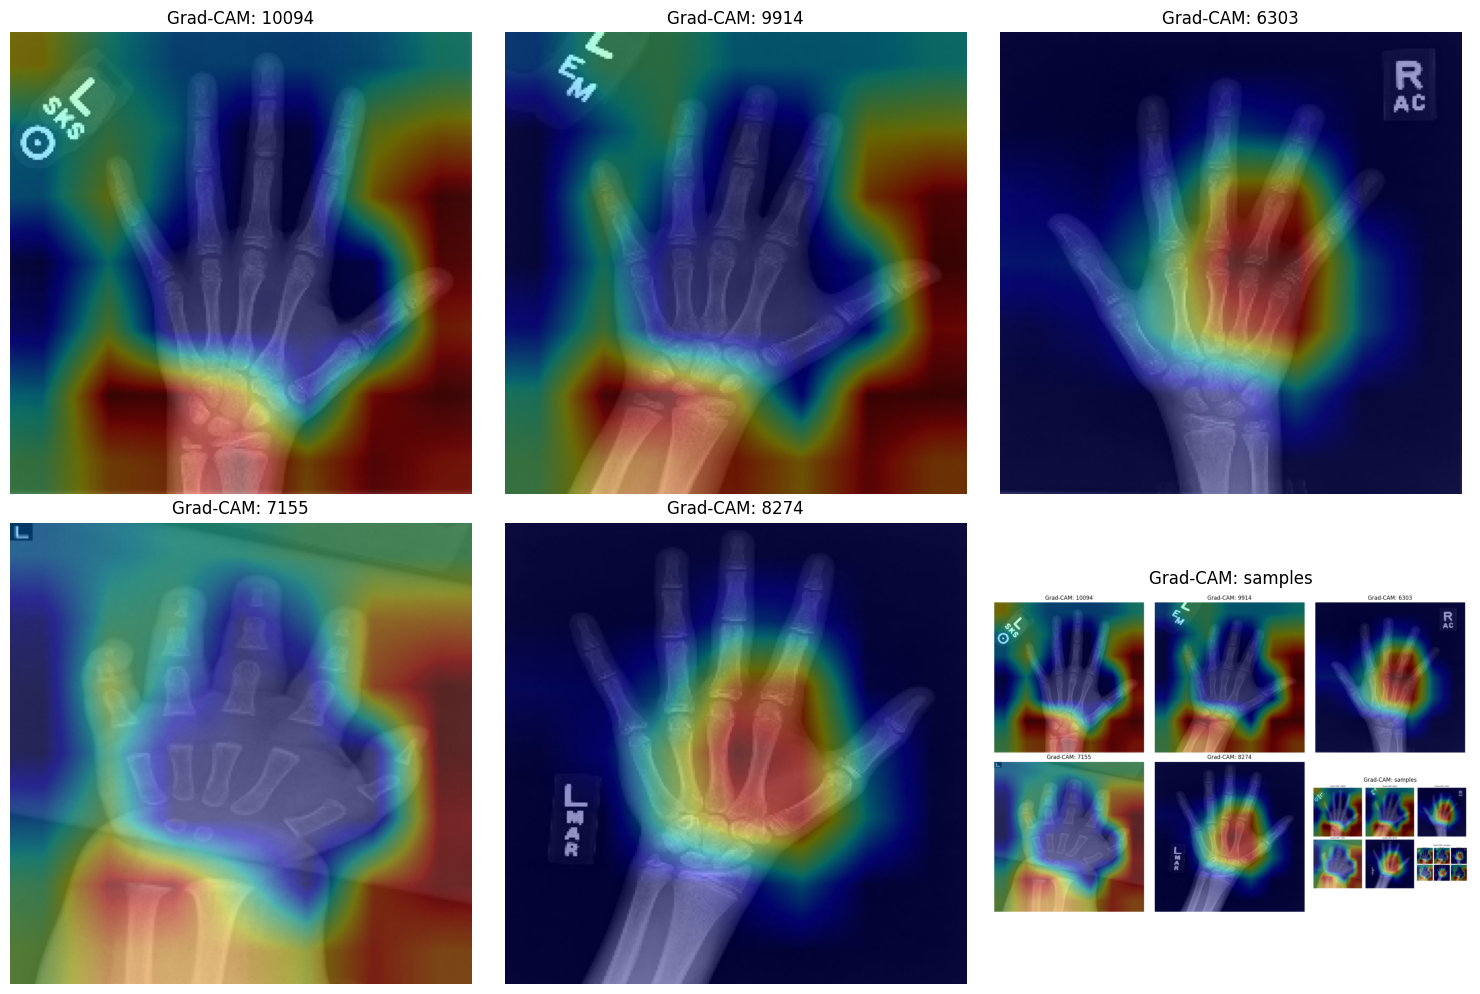

In [24]:
print('PART 3: GRAD-CAM VISUALIZATION')
# Add this import!
import matplotlib.cm as cm

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])

        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

os.makedirs('results/heatmaps', exist_ok=True)
last_conv_layer_name = 'conv5_block3_out'
sample_images = df_test.sample(min(12, len(df_test)), random_state=RANDOM_STATE)

print('\nGenerating Grad-CAM heatmaps...')
generated_count = 0

for i, (idx, row) in enumerate(sample_images.iterrows()):

    img_path = os.path.join(TRAIN_DIR, f"{row['id']}.png")
    if not os.path.exists(img_path):
        continue

    # Load + preprocess
    img_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE))
    img_array = np.stack([img] * 3, axis=-1) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Heatmap
    heatmap = make_gradcam_heatmap(img_array, cnn_cls_model, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_colored = cm.jet(heatmap_resized)[:, :, :3]

    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) / 255.0
    superimposed = heatmap_colored * 0.4 + img_rgb * 0.6

    save_path = f'results/heatmaps/gradcam_{row["id"]}.png'
    plt.imsave(save_path, np.clip(superimposed, 0, 1))

    generated_count += 1
    if generated_count % 3 == 0:
        print(f'  Generated {generated_count}/{len(sample_images)} heatmaps')

print(f'\nSaved {generated_count} Grad-CAM heatmaps to results/heatmaps/')

# Display samples
print('\nDisplaying sample Grad-CAM visualizations...')
display_count = min(6, generated_count)

if display_count > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    heatmap_files = [
        f for f in os.listdir('results/heatmaps')
        if f.startswith('gradcam_')
    ][:display_count]

    for idx, filename in enumerate(heatmap_files):
        img = plt.imread(os.path.join('results/heatmaps', filename))
        axes[idx].imshow(img)
        axes[idx].set_title(f'Grad-CAM: {filename[8:-4]}')
        axes[idx].axis('off')

    # hide extra
    for idx in range(display_count, 6):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('results/heatmaps/gradcam_samples.png', dpi=100, bbox_inches='tight')
    plt.show()

## 14. Model Comparison

In [25]:
comparison_df = pd.DataFrame([
    {
        'Model': 'Classical ML (RF)',
        'MAE': classical_reg_results['test_mae'],
        'RMSE': classical_reg_results['test_rmse'],
        'R2': classical_reg_results['test_r2']
    },
    {
        'Model': 'Deep Learning (CNN)',
        'MAE': cnn_reg_results['test_mae'],
        'RMSE': cnn_reg_results['test_rmse'],
        'R2': cnn_reg_results['test_r2']
    }
])

print('\nModel Comparison:')
print(comparison_df.to_string(index=False))


Model Comparison:
              Model      MAE     RMSE       R2
  Classical ML (RF) 2.313883 2.899171 0.273499
Deep Learning (CNN) 2.627068 3.306089 0.055248


## 15. Visualization - Scatter Plots

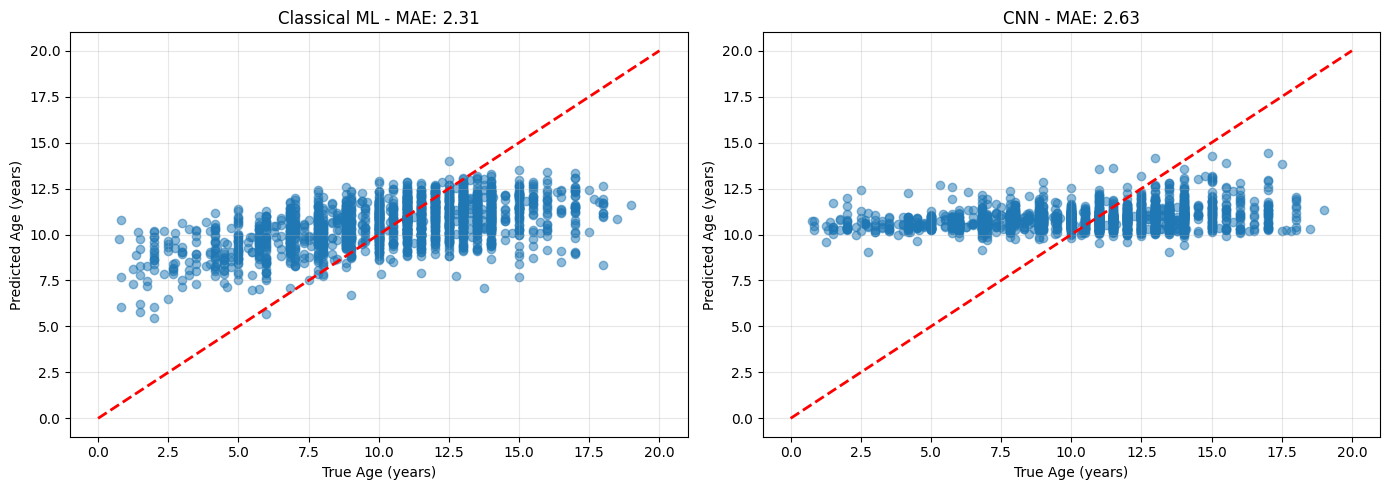

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test_reg, classical_reg_results['predictions'], alpha=0.5)
axes[0].plot([0, 20], [0, 20], 'r--', lw=2)
axes[0].set_xlabel('True Age (years)')
axes[0].set_ylabel('Predicted Age (years)')
axes[0].set_title(f'Classical ML - MAE: {classical_reg_results["test_mae"]:.2f}')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_test_reg, cnn_reg_results['predictions'], alpha=0.5)
axes[1].plot([0, 20], [0, 20], 'r--', lw=2)
axes[1].set_xlabel('True Age (years)')
axes[1].set_ylabel('Predicted Age (years)')
axes[1].set_title(f'CNN - MAE: {cnn_reg_results["test_mae"]:.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/scatter_plots/regression_comparison.png')
plt.show()

## 16. Confusion Matrix

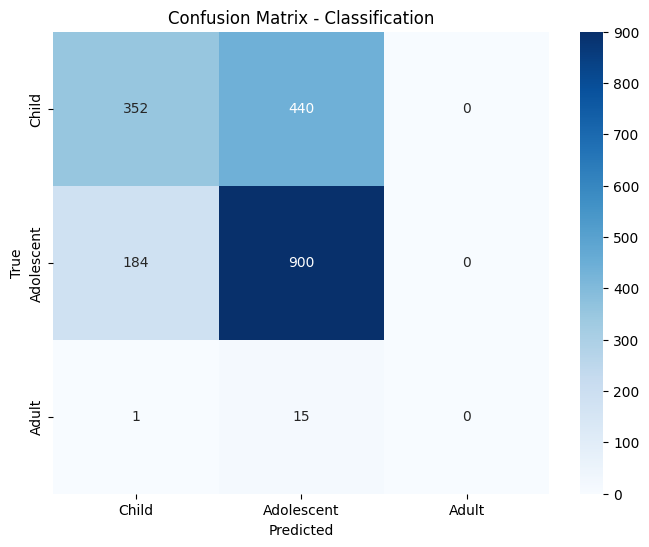

In [27]:
cm = confusion_matrix(y_test_cls, classical_cls_results['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adolescent', 'Adult'],
            yticklabels=['Child', 'Adolescent', 'Adult'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Classification')
plt.savefig('results/confusion_matrix/classification_cm.png')
plt.show()

## 17. Gender-wise Performance Analysis


Gender-wise Performance (CNN):
Male MAE: 2.715 years
Female MAE: 2.523 years
Difference: 0.192 years


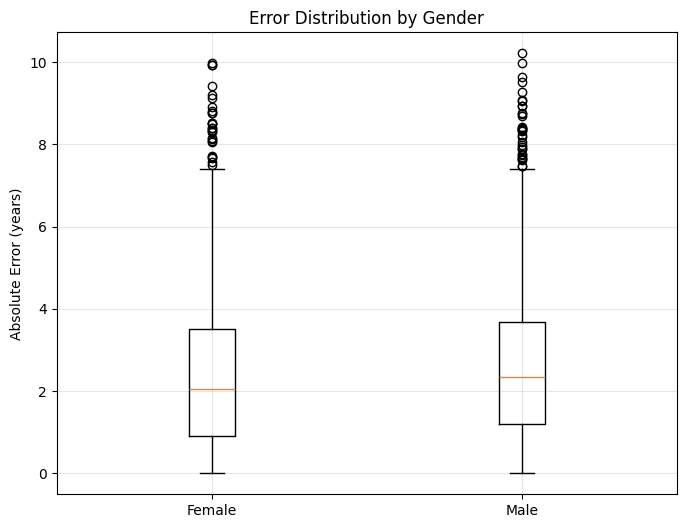

In [28]:
df_test['cnn_predictions'] = cnn_pred_test
df_test['error'] = np.abs(df_test['age_years'] - df_test['cnn_predictions'])

male_errors = df_test[df_test['male'] == True]['error']
female_errors = df_test[df_test['male'] == False]['error']

male_mae = male_errors.mean()
female_mae = female_errors.mean()

print(f'\nGender-wise Performance (CNN):')
print(f'Male MAE: {male_mae:.3f} years')
print(f'Female MAE: {female_mae:.3f} years')
print(f'Difference: {abs(male_mae - female_mae):.3f} years')

plt.figure(figsize=(8, 6))
plt.boxplot([female_errors, male_errors], labels=['Female', 'Male'])
plt.ylabel('Absolute Error (years)')
plt.title('Error Distribution by Gender')
plt.grid(True, alpha=0.3)
plt.savefig('results/gender_bias_analysis.png')
plt.show()

## 18. Age Group Error Analysis


Error by Age Group:
               mean       std  count
age_group                           
0-5        6.973706  1.313906    157
11-15      1.689833  1.152653    997
16+        5.350157  1.236402    103
6-10       2.582223  1.413537    635


<Figure size 1000x600 with 0 Axes>

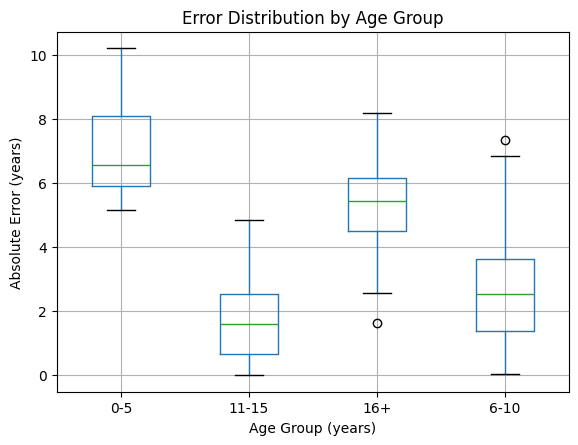

In [29]:
def age_group_label(age):
    if age <= 5:
        return '0-5'
    elif age <= 10:
        return '6-10'
    elif age <= 15:
        return '11-15'
    else:
        return '16+'

df_test['age_group'] = df_test['age_years'].apply(age_group_label)

age_group_stats = df_test.groupby('age_group')['error'].agg(['mean', 'std', 'count'])
print('\nError by Age Group:')
print(age_group_stats)

plt.figure(figsize=(10, 6))
df_test.boxplot(column='error', by='age_group')
plt.ylabel('Absolute Error (years)')
plt.xlabel('Age Group (years)')
plt.title('Error Distribution by Age Group')
plt.suptitle('')
plt.savefig('results/age_group_analysis.png')
plt.show()

## 19. Worst Predictions Analysis

Top 10 Worst Predictions:
   id  age_years  cnn_predictions     error  male
14328   1.500000        11.716646 10.216646  True
12037   2.000000        11.991614  9.991614  True
 7155   0.750000        10.731023  9.981023 False
 4237   2.500000        12.425925  9.925925 False
 3935   0.833333        10.757519  9.924185 False
10186   0.833333        10.472016  9.638683  True
 9182   2.000000        11.526725  9.526725  True
 8269   0.833333        10.254772  9.421439 False
 3998   1.416667        10.698939  9.282273  True
 3020   1.250000        10.458158  9.208158 False


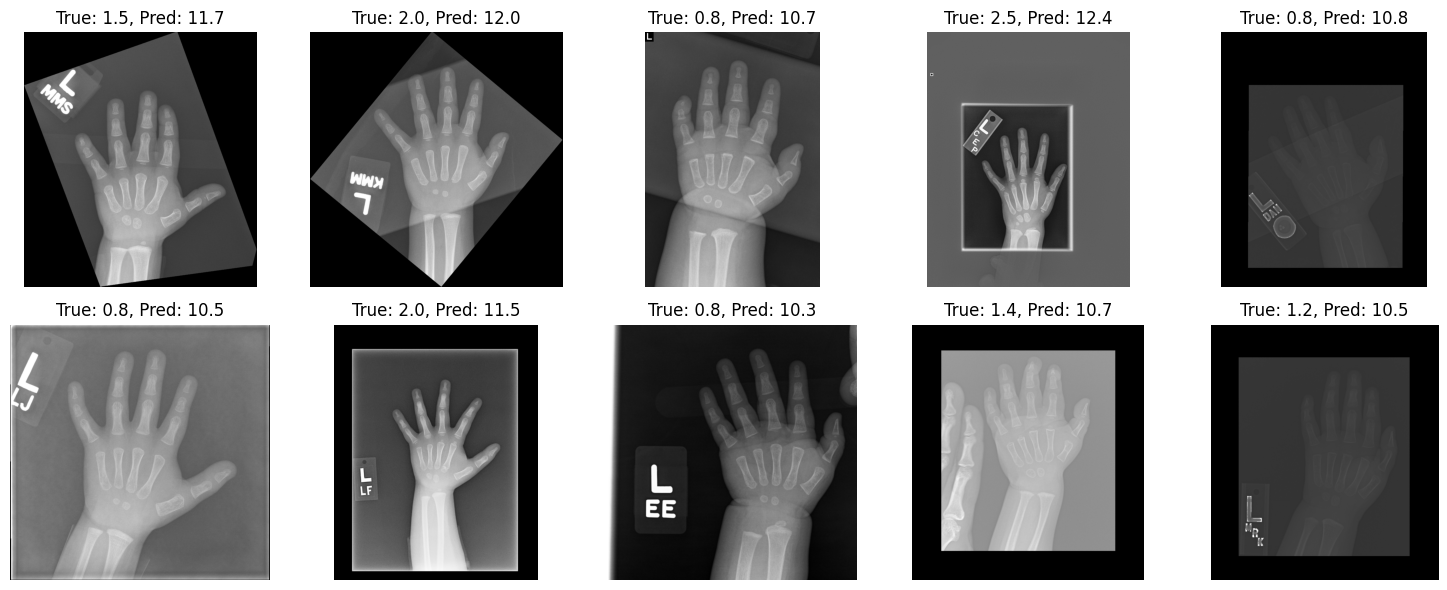

In [30]:
worst_10 = df_test.nlargest(10, 'error')

print('Top 10 Worst Predictions:')
print(worst_10[['id', 'age_years', 'cnn_predictions', 'error', 'male']].to_string(index=False))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, (i, row) in enumerate(worst_10.iterrows()):
    img_path = os.path.join(TRAIN_DIR, f"{row['id']}.png")  # Changed to TRAIN_DIR
    
    # Add error handling
    if not os.path.exists(img_path):
        axes[idx].text(0.5, 0.5, 'Image\nNot Found', 
                      ha='center', va='center', fontsize=12)
        axes[idx].set_title(f"True: {row['age_years']:.1f}, Pred: {row['cnn_predictions']:.1f}")
        axes[idx].axis('off')
        continue
        
    img = Image.open(img_path)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"True: {row['age_years']:.1f}, Pred: {row['cnn_predictions']:.1f}")
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('results/worst_predictions.png', dpi=100, bbox_inches='tight')
plt.show()

## 20. Results Summary

In [31]:
summary = f"""
BONE AGE PREDICTION - RESULTS SUMMARY

Dataset:
- Training samples: {len(train_df)}
- Validation samples: {len(val_df)}
- Test samples: {len(df_test)}

Regression Performance:
Classical ML (Random Forest):
  MAE: {classical_reg_results['test_mae']:.3f} years
  RMSE: {classical_reg_results['test_rmse']:.3f} years
  R2: {classical_reg_results['test_r2']:.3f}

Deep Learning (CNN ResNet50):
  MAE: {cnn_reg_results['test_mae']:.3f} years
  RMSE: {cnn_reg_results['test_rmse']:.3f} years
  R2: {cnn_reg_results['test_r2']:.3f}

Classification Performance (Random Forest):
  Accuracy: {classical_cls_results['test_acc']:.3f}
  F1-Score: {classical_cls_results['f1']:.3f}
  Quadratic Weighted Kappa: {classical_cls_results['qwk']:.3f}

Gender Bias Analysis:
  Male MAE: {male_mae:.3f} years
  Female MAE: {female_mae:.3f} years
  Difference: {abs(male_mae - female_mae):.3f} years
"""

print(summary)

with open('report/results_summary.txt', 'w') as f:
    f.write(summary)


BONE AGE PREDICTION - RESULTS SUMMARY

Dataset:
- Training samples: 9111
- Validation samples: 1608
- Test samples: 1892

Regression Performance:
Classical ML (Random Forest):
  MAE: 2.314 years
  RMSE: 2.899 years
  R2: 0.273

Deep Learning (CNN ResNet50):
  MAE: 2.627 years
  RMSE: 3.306 years
  R2: 0.055

Classification Performance (Random Forest):
  Accuracy: 0.662
  F1-Score: 0.645
  Quadratic Weighted Kappa: 0.289

Gender Bias Analysis:
  Male MAE: 2.715 years
  Female MAE: 2.523 years
  Difference: 0.192 years

